In [24]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
from pathlib import Path
import anndata as ad
import scanpy as sc
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from matplotlib import pyplot as plt

sys.path.insert(0, "/home/ylu/project")
from utils import *
import time

from tqdm import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import SPACEL
from SPACEL import Scube, Splane

In [26]:
# Load DLPFC data
data_folder = "../../data/STARMapPlus/"
results_folder = "./partial_results/"
cache_folder = os.path.join(results_folder, 'Scube_outputs')
Path(cache_folder).mkdir(parents=True, exist_ok=True)

# adata_names = 'sagittal2'
adata_names = 'well_08'
        
adata = ad.read_h5ad(os.path.join(data_folder,"{}.h5ad".format(adata_names)))
scale = np.linalg.norm(adata.obsm['spatial'].max(0) - adata.obsm['spatial'].min(0))

In [27]:
# split into slices
slices = split_slice(
    adata=adata,
    spatial_key='spatial_raw',
    split_num=15,
    axis=2,
)[:-1]
interval = len(slices) // 2
        
# Evaluate SPACEL
overlay_ratios = np.linspace(0.3, 1, 8)
alignment_accuracy_results = []

In [28]:
slices[0]

AnnData object with n_obs × n_vars = 2889 × 1022
    obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'slice'
    obsm: 'spatial', 'spatial_raw'

In [17]:
i = 0
slice1 = slices[i].copy()
slice2 = slices[i+1].copy()
slice1_crop, slice2_crop = crop_slices(
    slice1, 
    slice2, 
    spatial_key='spatial', 
    overlay_ratio = 0.6,
)

In [18]:
slice1_crop.obsm['spatial_rot'] = slice1_crop.obsm['spatial'].copy()
rigid_transformation(slice2_crop, spatial_key, 'spatial_rot')

AnnData object with n_obs × n_vars = 8255 × 1022
    obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'slice'
    obsm: 'spatial', 'spatial_raw', 'spatial_rot'

In [19]:
key_added = 'align_spatial'
spatial_key = 'spatial_rot'
anno_key = 'Main_molecular_tissue_region'

In [20]:
align_slices = [slice1_crop, slice2_crop]
# align slices
Scube.align(
    align_slices,
    cluster_key=anno_key, 
    n_neighbors = 15, 
    n_threads=10,
    p=2,
    write_loc_path=os.path.join(results_folder, 'Scube_outputs/aligned_coordinates.csv')
)
align_slices[0].obsm[key_added] = align_slices[0].obsm['spatial_aligned'].values
align_slices[1].obsm[key_added] = align_slices[1].obsm['spatial_aligned'].values

Start alignment...
Alignment slice 1 to 0
Runtime: 137.3619647026062 s


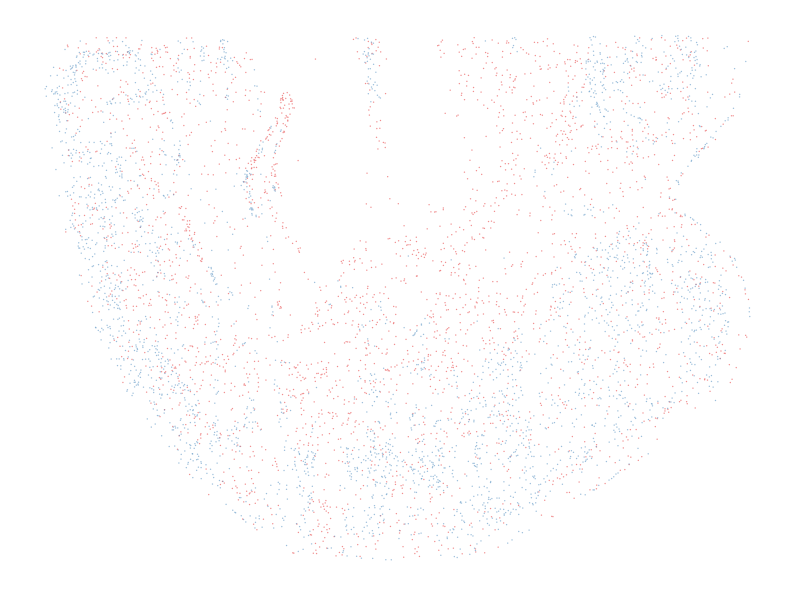

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_overlay(
    align_slices, 
    key_added,
    ax,
    point_size=1,
    label_key=None,
    palette = "Set1",
    title = '',
    legend=False,
    fontsize=8,
)
plt.show()

In [29]:
key_added = 'align_spatial'
spatial_key = 'spatial'
anno_key = 'Main_molecular_tissue_region'

for i in range(interval):
    slice1 = slices[i].copy()
    slice2 = slices[i+interval].copy()
    for overlay_ratio in overlay_ratios:
        slice1_crop, slice2_crop = crop_slices(
            slice1, 
            slice2, 
            spatial_key='spatial', 
            overlay_ratio = overlay_ratio,
        )
        slice1_crop.obsm['spatial_rot'] = slice1_crop.obsm['spatial'].copy()
        rigid_transformation(slice2_crop, spatial_key, 'spatial_rot')
        slice1_crop.obsm['spatial_ori'] = slice1_crop.obsm['spatial'].copy()
        slice2_crop.obsm['spatial_ori'] = slice2_crop.obsm['spatial'].copy()
        slice1_crop.obsm['spatial'] = slice1_crop.obsm['spatial_rot'].copy()
        slice2_crop.obsm['spatial'] = slice2_crop.obsm['spatial_rot'].copy()
        align_slices = [slice1_crop, slice2_crop]
        # align slices
        Scube.align(
            align_slices,
            cluster_key=anno_key, 
            n_neighbors = 15, 
            n_threads=10,
            p=2,
            write_loc_path=os.path.join(results_folder, 'Scube_outputs/aligned_coordinates.csv')
        )
        align_slices[0].obsm[key_added] = align_slices[0].obsm['spatial_aligned'].values
        align_slices[1].obsm[key_added] = align_slices[1].obsm['spatial_aligned'].values
        
        # R1, t1=solve_RT_by_correspondence(align_slices[1].obsm[key_added], align_slices[1].obsm[spatial_key])
        # R2, t2=solve_RT_by_correspondence(align_slices[0].obsm[spatial_key], align_slices[0].obsm[key_added])
        # t = t1 @ R2.T + t2
        # R = R2 @ R1
        R, t = solve_RT_by_correspondence(align_slices[0].obsm['spatial_ori'], align_slices[0].obsm[key_added])
        align_spatial = align_slices[1].obsm[key_added] @ R.T + t
        spatial_GT = align_slices[1].obsm["spatial_ori"]
        
        # calculate the metrics
        mae, mae_var = MAE(align_spatial / scale, spatial_GT / scale)
        mse, mse_var = MSE(align_spatial / scale, spatial_GT / scale)
        
        alignment_accuracy_results.append([mae, mae_var, mse, mse_var, overlay_ratio])

# save the results
np.save(os.path.join(results_folder,'STARMap_{}_SPACEL_partial_results.npy'.format(adata_names)), alignment_accuracy_results, allow_pickle=True)

Start alignment...
Alignment slice 1 to 0
Runtime: 70.12392711639404 s
Start alignment...
Alignment slice 1 to 0
Runtime: 47.49654197692871 s
Start alignment...
Alignment slice 1 to 0
Runtime: 49.005611181259155 s
Start alignment...
Alignment slice 1 to 0
Runtime: 49.094173431396484 s
Start alignment...
Alignment slice 1 to 0
Runtime: 47.93656015396118 s
Start alignment...
Alignment slice 1 to 0
Runtime: 57.045846939086914 s
Start alignment...
Alignment slice 1 to 0
Runtime: 51.6929886341095 s
Start alignment...
Alignment slice 1 to 0
Runtime: 50.66921019554138 s
Start alignment...
Alignment slice 1 to 0
Runtime: 18.434800386428833 s
Start alignment...
Alignment slice 1 to 0
Runtime: 27.415952682495117 s
Start alignment...
Alignment slice 1 to 0
Runtime: 22.409040927886963 s
Start alignment...
Alignment slice 1 to 0
Runtime: 21.895549058914185 s
Start alignment...
Alignment slice 1 to 0
Runtime: 22.74887490272522 s
Start alignment...
Alignment slice 1 to 0
Runtime: 26.135485887527466 s